In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler;
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
import joblib
import scienceplots
import os 
import re
import random

### Functions

Verification of distribution of DATA

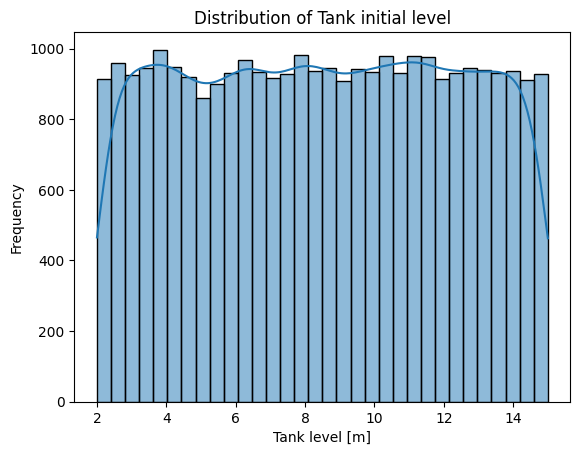

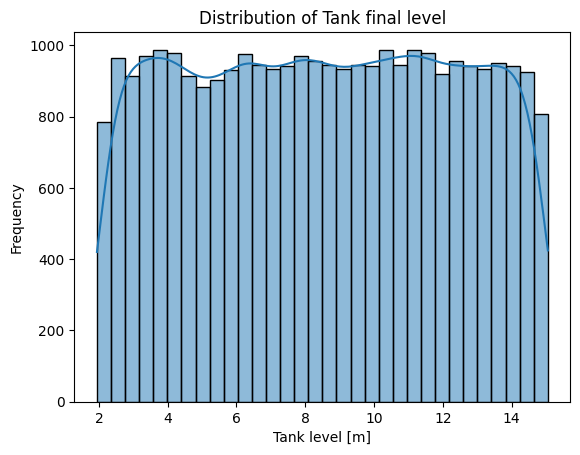

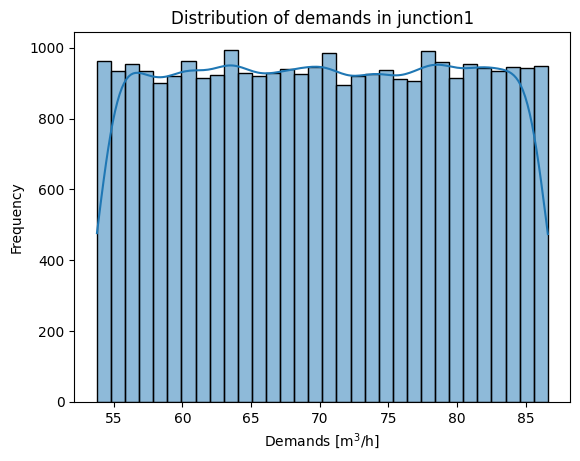

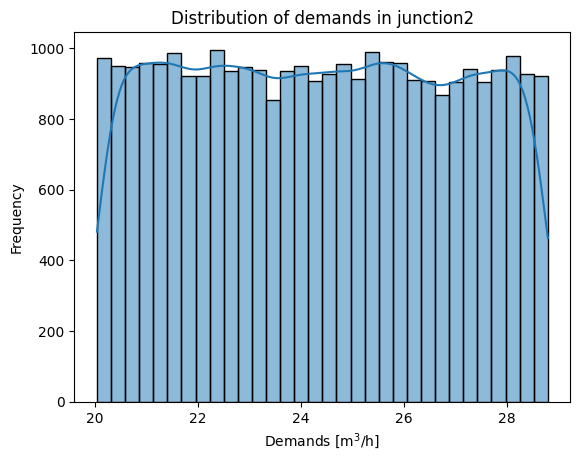

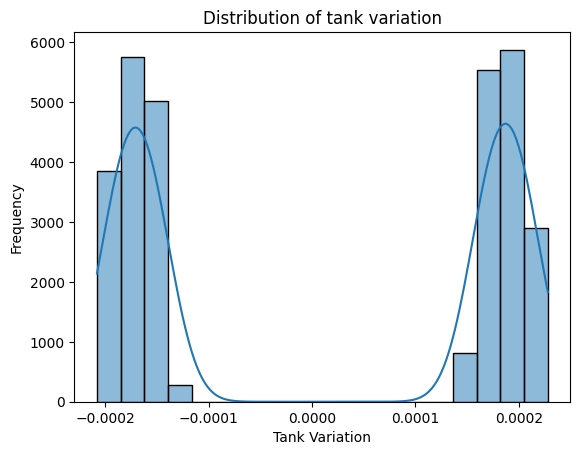

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 


df_plot = pd.read_csv(r'C:\Users\LENOVO\OneDrive - Universidade de Aveiro\universidade\Mestrado\2º Ano\Tese\Códigos\Test_epanet\samples\Fontinha\samples_30_000.csv', index_col=False)
df_out_plot = pd.read_csv(r'C:\Users\LENOVO\OneDrive - Universidade de Aveiro\universidade\Mestrado\2º Ano\Tese\Códigos\Test_epanet\samples\Fontinha\samples_out_30_000.csv', index_col=False)
tank = df_plot.tank_0
demand1 = df_plot.junction_1
demand2 = df_plot.junction_2
tank_var = df_out_plot.Δtank_0
tank_final = df_plot.tank_final_0



# Create a histogram with a kernel density estimate
sns.histplot(data=tank, kde=True)
plt.title('Distribution of Tank initial level')
plt.xlabel('Tank level [m]')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data=tank_final, kde=True)
plt.title('Distribution of Tank final level')
plt.xlabel('Tank level [m]')
plt.ylabel('Frequency')
plt.savefig("distribution_tank_level.pdf")
plt.show()


sns.histplot(data=demand1, kde=True)
plt.title('Distribution of demands in junction1')
plt.xlabel('Demands [m$^3$/h]')
plt.ylabel('Frequency')
plt.savefig("distribution_junction1.pdf")
plt.show()

sns.histplot(data=demand2, kde=True)
plt.title('Distribution of demands in junction2')
plt.xlabel('Demands [m$^3$/h]')
plt.ylabel('Frequency')
plt.savefig("distribution_junction2.pdf")
# Display the plots
plt.show()

sns.histplot(data=tank_var, kde=True)
plt.title('Distribution of tank variation')
plt.xlabel('Tank Variation')
plt.ylabel('Frequency')
# Display the plots
plt.show()

# Fontinha

## Importar e analisar os dados 

In [4]:
epanet_data = pd.read_csv(r'C:\Users\LENOVO\OneDrive - Universidade de Aveiro\universidade\Mestrado\2º Ano\Tese\Códigos\Test_epanet\Samples\Fontinha\samples_30_000.csv', index_col=False)
real_out=  pd.read_csv(r'C:\Users\LENOVO\OneDrive - Universidade de Aveiro\universidade\Mestrado\2º Ano\Tese\Códigos\Test_epanet\Samples\Fontinha\samples_out_30_000.csv', index_col=False)
epanet_data.head()
#dados.columns
#dados.shape

,t_step,tank_0,pumps_0,pumps_kw_0,junction_1,junction_2,tank_final_0
0,300,6.9566,1.0,129.08,55.939980,27.550770,7.0196
1,300,12.0797,0.0,0.00,64.386879,24.072510,12.0318
2,300,14.0778,0.0,0.00,72.953674,25.716810,14.0244
3,300,8.1666,0.0,0.00,78.034760,20.685646,8.1131
4,300,2.4593,1.0,127.94,76.539948,25.089571,2.5135


In [5]:
epanet_data.describe()

,t_step,tank_0,pumps_0,pumps_kw_0,junction_1,junction_2,tank_final_0
count,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,300.0,8.503629,0.503567,65.469601,70.210671,24.392997,8.506445
std,0.0,3.747528,0.499996,65.011416,9.492245,2.534496,3.747500
min,300.0,2.000200,0.000000,0.000000,53.787262,20.041473,1.941100
25%,300.0,5.265300,0.000000,0.000000,62.014751,22.197207,5.261200
50%,300.0,8.512750,1.000000,127.550000,70.210320,24.391835,8.516450
75%,300.0,11.723225,1.000000,130.040000,78.443878,26.578460,11.729675
max,300.0,14.999500,1.000000,132.630000,86.603218,28.797905,15.056800


In [6]:
real_out = real_out.drop(columns=['pumps_energy'])

In [7]:
real_out['pumps_kw'] =epanet_data['pumps_kw_0']
real_out.head(10)

,Δtank_0,pumps_kw
0,0.000210,129.08
1,-0.000160,0.00
2,-0.000178,0.00
3,-0.000178,0.00
4,0.000181,127.94
5,-0.000194,0.00
6,0.000159,129.40
7,-0.000185,0.00
8,0.000222,129.51
9,0.000178,132.18


## Variação do nivel do tank e acerto unidades dos demands

-> Não vou acertar as unidades para m^3/h porque tenho os meus dados em seg. então deixo ficar em L/s

-> Para o caso do dynamic samples não preciso fazer o tank_variation porque já tenho num ficheiro real_out

Shuffling data has the effect of reducing variance and making sure that models remain general and overfit less.

In [8]:
# #shuffle rows and reset index ### DO NOT DO IT FOR TIME-SERIES DATA
# epanet_data =epanet_data.sample(frac=1).reset_index(drop=True)[:50000]
# epanet_data

## SPLIT

Vou definir o que é o meu input (**x**), e o meu output (**y**)

x - tank level; pump state; demands

y = Δtank; pumps_kw (Power)

In [9]:
# In
X = epanet_data.loc[:, 'tank_0':'junction_2']; X = X.drop(columns=['pumps_kw_0'])
# Out
y= real_out.loc[:,['Δtank_0', 'pumps_kw']]
new_x = X.copy()

### Train/ Test split

In [10]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((21600, 4), (3000, 4))

## Standardize Tanks and demands

Machine Learning algorithms don´t perform well when the input numerical attributes have very different scales.  
**(Hands on machine learning (book))**
 In order to get all attributes to have the same scale a standardization was made. 


In [11]:
X_train_norm=X_train.copy()
y_train_norm=y_train.copy()
x_test_norm=X_test.copy()
y_test_norm=y_test.copy()
x_val_norm=X_val.copy()
y_val_norm=y_val.copy()


# Specify the columns you want to normalize
columns_to_normalize1 = ['tank_0', 'junction_1', 'junction_2']
columns_to_normalize2 = ['Δtank_0', 'pumps_kw']

# Initialize the MinMaxScaler and normalize columns
scaler_in = MinMaxScaler()
scaler_out = MinMaxScaler()

# For train
X_train_norm[columns_to_normalize1] = scaler_in.fit_transform(X_train[columns_to_normalize1])
y_train_norm[columns_to_normalize2] = scaler_out.fit_transform(y_train[columns_to_normalize2])

# For test
x_test_norm[columns_to_normalize1] = scaler_in.transform(X_test[columns_to_normalize1])
y_test_norm[columns_to_normalize2] = scaler_out.transform(y_test[columns_to_normalize2])
# For val
x_val_norm[columns_to_normalize1] = scaler_in.transform(X_val[columns_to_normalize1])
y_val_norm[columns_to_normalize2] = scaler_out.transform(y_val[columns_to_normalize2])

In [12]:
scaler_in.feature_names_in_

array(['tank_0', 'junction_1', 'junction_2'], dtype=object)

In [13]:
scaler_out.feature_names_in_

array(['Δtank_0', 'pumps_kw'], dtype=object)

Organizar dataset

In [14]:
X_train_norm.columns

Index(['tank_0', 'pumps_0', 'junction_1', 'junction_2'], dtype='object')

## Modelo XGBOOST

### Fitting the model and predicting

Actual working training models

In [15]:
# Parâmetros escolhidos por hyperparameter tunning
xgb_model = xgb.XGBRegressor(learning_rate=0.05,max_depth=20,gama=0, reg_lambda = 0.7, reg_alpha = 0.8, n_estimators=250,eval_metric="rmse") 

# ter atençao de usar dados normalizados!
xgb_model.fit(X_train_norm, y_train_norm, eval_set=[(X_train_norm, y_train_norm),(x_val_norm,y_val_norm)],early_stopping_rounds=10) 

y_pred1 = xgb_model.predict(x_test_norm) # prediction



[15:39:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gama" } are not used.

[0]	validation_0-rmse:0.43032	validation_1-rmse:0.43044
[1]	validation_0-rmse:0.40883	validation_1-rmse:0.40894
[2]	validation_0-rmse:0.38842	validation_1-rmse:0.38851
[3]	validation_0-rmse:0.36902	validation_1-rmse:0.36910
[4]	validation_0-rmse:0.35060	validation_1-rmse:0.35066
[5]	validation_0-rmse:0.33310	validation_1-rmse:0.33315
[6]	validation_0-rmse:0.31647	validation_1-rmse:0.31651
[7]	validation_0-rmse:0.30068	validation_1-rmse:0.30071
[8]	validation_0-rmse:0.28567	validation_1-rmse:0.28569
[9]	validation_0-rmse:0.27142	validation_1-rmse:0.27142
[10]	validation_0-rmse:0.25788	validation_1-rmse:0.25788
[11]	validation_0-rmse:0.24502	validation_1-rmse:0.24500
[12]	validation_0-rmse:0.23280	validation_1-rmse:0.23277


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-rmse:0.22119	validation_1-rmse:0.22116
[14]	validation_0-rmse:0.21016	validation_1-rmse:0.21012
[15]	validation_0-rmse:0.19969	validation_1-rmse:0.19964
[16]	validation_0-rmse:0.18974	validation_1-rmse:0.18968
[17]	validation_0-rmse:0.18028	validation_1-rmse:0.18022
[18]	validation_0-rmse:0.17130	validation_1-rmse:0.17123
[19]	validation_0-rmse:0.16277	validation_1-rmse:0.16270
[20]	validation_0-rmse:0.15466	validation_1-rmse:0.15459
[21]	validation_0-rmse:0.14697	validation_1-rmse:0.14689
[22]	validation_0-rmse:0.13965	validation_1-rmse:0.13957
[23]	validation_0-rmse:0.13270	validation_1-rmse:0.13262
[24]	validation_0-rmse:0.12610	validation_1-rmse:0.12602
[25]	validation_0-rmse:0.11983	validation_1-rmse:0.11975
[26]	validation_0-rmse:0.11387	validation_1-rmse:0.11379


[27]	validation_0-rmse:0.10822	validation_1-rmse:0.10814
[28]	validation_0-rmse:0.10284	validation_1-rmse:0.10276
[29]	validation_0-rmse:0.09773	validation_1-rmse:0.09765
[30]	validation_0-rmse:0.09288	validation_1-rmse:0.09280
[31]	validation_0-rmse:0.08827	validation_1-rmse:0.08819
[32]	validation_0-rmse:0.08390	validation_1-rmse:0.08382
[33]	validation_0-rmse:0.07974	validation_1-rmse:0.07966
[34]	validation_0-rmse:0.07579	validation_1-rmse:0.07571
[35]	validation_0-rmse:0.07203	validation_1-rmse:0.07196
[36]	validation_0-rmse:0.06847	validation_1-rmse:0.06839
[37]	validation_0-rmse:0.06508	validation_1-rmse:0.06500
[38]	validation_0-rmse:0.06186	validation_1-rmse:0.06179
[39]	validation_0-rmse:0.05881	validation_1-rmse:0.05873
[40]	validation_0-rmse:0.05590	validation_1-rmse:0.05583
[41]	validation_0-rmse:0.05315	validation_1-rmse:0.05307
[42]	validation_0-rmse:0.05053	validation_1-rmse:0.05046
[43]	validation_0-rmse:0.04804	validation_1-rmse:0.04797
[44]	validation_0-rmse:0.04568	

In [16]:
y_pred_df = pd.DataFrame(data=y_pred1, columns=y_test.columns)

### Saving the model and scalers

In [17]:
# save the model to a file
joblib.dump(xgb_model, 'xgb_model_fontinha.joblib')
joblib.dump(scaler_in,'scaler_in_fontinha.joblib')
joblib.dump(scaler_out, 'scaler_out_fontinha.joblib')

# the First parameter is the name of the model and the second parameter is the name of the file
# with which we want to save it

# now the model named 'reg' will be saved as 'xgb_model.joblib' in the current
# directory.

['scaler_out_fontinha.joblib']

In [18]:
xgb_model = joblib.load('xgb_model_fontinha2.joblib')

### Un-normalize

In [19]:
columns_to_unnormalize2 = ['Δtank_0', 'pumps_kw']
inverse_pred = pd.DataFrame(scaler_out.inverse_transform(y_pred_df[columns_to_unnormalize2]), columns=columns_to_unnormalize2)

### Metrics on Train

In [20]:
# Metrics
rmse_dict = {}

for column in y_test.columns:
    rmse = np.sqrt(mean_squared_error(y_test[column],inverse_pred[column]))
    rmse_dict[column] = rmse
    
mse_dict = {}
for column in y_test.columns:
    mse = mean_squared_error(y_test[column],inverse_pred[column])
    mse_dict[column] = mse

r2_dict = {}
for column in y_test.columns:
    r2 = r2_score(y_test[column],inverse_pred[column])
    r2_dict[column] = r2
    


df_metrics =pd.DataFrame({'RMSE': rmse_dict, 'MSE': mse_dict, 'R2': r2_dict})
print(df_metrics)


                  RMSE           MSE       R2
Δtank_0   5.718621e-07  3.270262e-13  0.99999
pumps_kw  4.250572e-02  1.806736e-03  1.00000


### Plots

In [21]:
# Plot the learning curve
train_rmse = xgb_model.evals_result()['validation_0']['rmse']
val_rmse = xgb_model.evals_result()['validation_1']['rmse']
num_rounds = range(len(train_rmse))

In [22]:
imagens_tese = r'C:\Users\LENOVO\OneDrive - Universidade de Aveiro\universidade\Mestrado\2º Ano\Tese\Tese_UA\Imagens'

dict_keys(['validation_0', 'validation_1'])


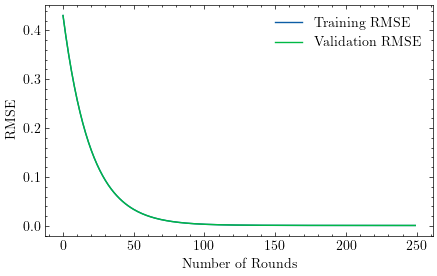

In [23]:
fig_size = (5, 3)

with plt.style.context('science'):
    # Create a figure with specified size
    fig, ax = plt.subplots(figsize=fig_size)

    print(xgb_model.evals_result_.keys())
    ax.plot(xgb_model.evals_result_['validation_0']['rmse'], label='Training RMSE')
    ax.plot(xgb_model.evals_result_['validation_1']['rmse'], label='Validation RMSE')
    ax.set_xlabel('Number of Rounds')
    ax.set_ylabel('RMSE')
    #ax.set_title('XGBoost Learning Curve')
    ax.legend()
    # Save and show the plot
    plt.savefig(os.path.join(imagens_tese, "Fontinha_learning_curve.pdf"), dpi=300)
    plt.show()

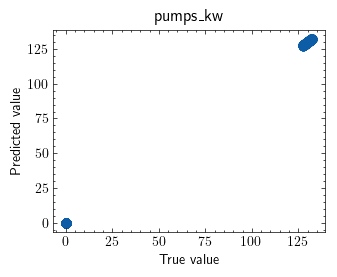

In [28]:
with plt.style.context('science'):
    plt.scatter(y_test['pumps_kw'],inverse_pred['pumps_kw'])
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title ('pumps_kw')
    plt.show

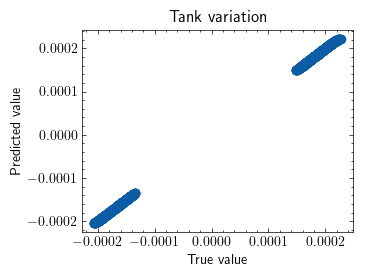

In [29]:
with plt.style.context('science'):
    plt.scatter(y_test['Δtank_0'],inverse_pred['Δtank_0'])
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title ('Tank variation')
    plt.show

## Cross Testing

In [30]:
#data_manual=pd.read_csv(r'C:\Users\LENOVO\OneDrive - Universidade de Aveiro\universidade\Mestrado\2º Ano\Tese\Códigos\Test_epanet\Samples\Fontinha\48h_5min_fontinha_manual.csv', index_col=False)
data_manual=pd.read_csv(r'C:\Users\LENOVO\OneDrive - Universidade de Aveiro\universidade\Mestrado\2º Ano\Tese\Códigos\Test_epanet\Samples\fontinha_test.csv', index_col=False)

data_manual['t_step'][0]=300
data_manual.head()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19320\1831169914.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_manual['t_step'][0]=300


,time,t_step,tank_0,tank_final_0,pumps_0,pumps_kw_0,junction_1,junction_2
0,0,300,4.0000,4.0567,1.0,129.18,74.809998,20.041
1,300,300,4.0567,4.1135,1.0,129.19,74.809998,20.041
2,600,300,4.1135,4.1702,1.0,129.21,74.809998,20.041
3,900,300,4.1702,4.2269,1.0,129.23,74.809998,20.041
4,1200,300,4.2269,4.2836,1.0,129.25,74.809998,20.041


In [32]:
manual_expected = pd.DataFrame()
manual_expected['Final_Tank']= data_manual['tank_final_0']
manual_expected['pumps_kw'] = data_manual['pumps_kw_0']
manual_expected.drop(manual_expected.index[-1], inplace=True)

In [33]:
data_manual_st = data_manual.copy()
# Tank variation
data_manual_st["Δtank_0"] = ((data_manual_st["tank_final_0"]-data_manual_st["tank_0"])/data_manual_st.t_step) #m/s
data_manual_st.drop(data_manual_st.index[-1], inplace=True)
#Pumps POWER
data_manual_st = data_manual_st.reindex(columns=['time','t_step', 'tank_0', 'pumps_0', 'junction_1', 'junction_2','tank_final_0',"Δtank_0",'pumps_kw_0',])
data_manual_st.rename(columns = {'pumps_kw_0':'pumps_kw'}, inplace = True)


data_manual_st.tail(5)

,time,t_step,tank_0,pumps_0,junction_1,junction_2,tank_final_0,Δtank_0,pumps_kw
291,84900,300,1.0801,0.0,75.289001,20.346001,1.0284,-0.000172,0.0
292,85200,300,1.0284,0.0,75.289001,20.346001,0.9766,-0.000173,0.0
293,85500,300,0.9766,0.0,75.289001,20.346001,0.9248,-0.000173,0.0
294,85800,300,0.9248,0.0,75.289001,20.346001,0.8730,-0.000173,0.0
295,86100,300,0.8730,0.0,75.289001,20.346001,0.8213,-0.000172,0.0


In [34]:
manual_in = data_manual_st.loc[:, 'time':'junction_2']
manual_out = data_manual_st.loc[:,'Δtank_0':'pumps_kw']

In [35]:
x_manual = manual_in.loc[:, 'tank_0':'junction_2']

y_manual= manual_out.copy()
y_manual.head(5)

,Δtank_0,pumps_kw
0,0.000189,129.18
1,0.000189,129.19
2,0.000189,129.21
3,0.000189,129.23
4,0.000189,129.25


In [36]:
x_manual.head(5)

,tank_0,pumps_0,junction_1,junction_2
0,4.0000,1.0,74.809998,20.041
1,4.0567,1.0,74.809998,20.041
2,4.1135,1.0,74.809998,20.041
3,4.1702,1.0,74.809998,20.041
4,4.2269,1.0,74.809998,20.041


In [37]:
nivel_inicial = x_manual['tank_0'][0]
x_novo = x_manual.drop(columns=['tank_0'])
print(x_novo.head(1))

   pumps_0  junction_1  junction_2
0      1.0   74.809998      20.041


In [38]:
# Import dos meu normalizadores (Sara)
scaler_in = joblib.load('scaler_in_fontinha2.joblib')
scaler_out = joblib.load('scaler_out_fontinha2.joblib')
xgb_model = joblib.load('xgb_model_fontinha2.joblib')


In [39]:
columns_to_normalize1 = ['tank_0', 'junction_1', 'junction_2']
columns_to_normalize2 = ['Δtank_0', 'pumps_kw']

### Making predictions - For cross testing


In [40]:
tank_final = []
potencia = []

for i in range(len(manual_in['t_step']) - 1):
    if manual_in['time'][i] == 0:
        final = nivel_inicial
        power = 0
    else:
        tank_0 = tank_final[-1]

        x_test = pd.DataFrame([[tank_0, x_novo['pumps_0'][i], x_novo['junction_1'][i], x_novo['junction_2'][i]]], columns=['tank_0', 'pumps_0', 'junction_1', 'junction_2'])
        dtime = manual_in['t_step'][i]

        # Normalization
        x_normalizado = x_test.copy()
        x_normalizado[columns_to_normalize1] = scaler_in.transform(x_normalizado[columns_to_normalize1])

        # Prediction
        y_pred = xgb_model.predict(x_normalizado)
        y_pred_df = pd.DataFrame(data=y_pred, columns=[columns_to_normalize2])

        # Desnormalizar
        y_pred_un = scaler_out.inverse_transform(y_pred_df[columns_to_normalize2])


        # Integration
        final = y_pred_un[0, 0] * dtime + tank_0
        power = y_pred_un[0,1]
    tank_final.append(final)
    potencia.append(power)

# Add the last element
tank_0 = tank_final[-1]
x_test = pd.DataFrame([[tank_0, x_manual['pumps_0'].iloc[-1], x_manual['junction_1'].iloc[-1], x_manual['junction_2'].iloc[-1]]], columns=['tank_0', 'pumps_0', 'junction_1', 'junction_2'])
dtime = manual_in['t_step'].iloc[-1]
x_normalizado = x_test.copy()
x_normalizado[columns_to_normalize1] = scaler_in.transform(x_normalizado[columns_to_normalize1])
y_pred = xgb_model.predict(x_test)
y_pred_df = pd.DataFrame(data=y_pred, columns=[columns_to_normalize2])
y_pred_un = scaler_out.inverse_transform(y_pred_df[columns_to_normalize2])
final = y_pred_un[0, 0] * dtime + tank_0
power = y_pred_un[0,1]
tank_final.append(final)
potencia.append(power)

In [41]:
y_manual_pred_df = pd.DataFrame(data=tank_final)
potencia_df = pd.DataFrame(data=potencia)

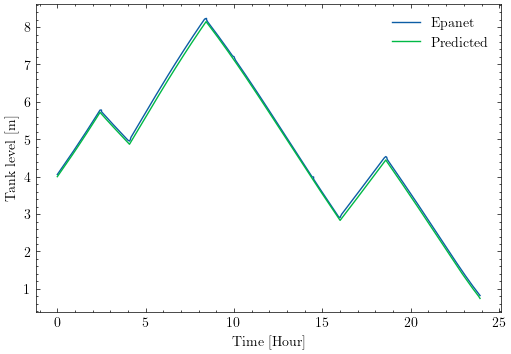

In [44]:
time_hour = manual_in['time']/3600
with plt.style.context('science'):
    plt.plot(time_hour,data_manual_st['tank_final_0'], label = 'Epanet')
    plt.plot(time_hour,y_manual_pred_df, label = 'Predicted')
    plt.legend()
    plt.xlabel('Time [Hour]')
    plt.ylabel('Tank level [m]')
    #plt.title('Tank level error propagation')
    plt.gcf().set_size_inches(6,4)
    plt.savefig(os.path.join(imagens_tese,"tank_level.pdf"), dpi=300)
    plt.show()

In [45]:
print(y_manual_pred_df)

            0
0    4.000000
1    4.056550
2    4.113100
3    4.169608
4    4.226116
..        ...
291  0.960360
292  0.908611
293  0.856862
294  0.805113
295  0.744020

[296 rows x 1 columns]


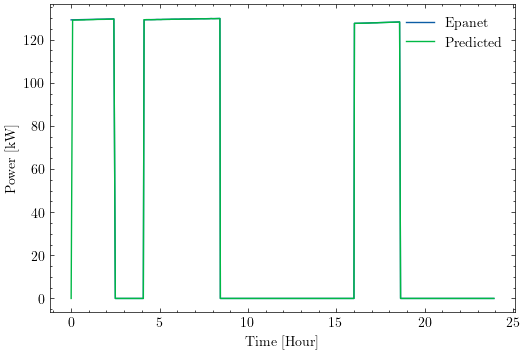

In [48]:
time_hour = manual_in['time']/3600

with plt.style.context('science'):
    plt.plot(time_hour,data_manual_st['pumps_kw'], label = 'Epanet')
    plt.plot(time_hour,potencia_df, label = 'Predicted')
    plt.legend(loc = 'upper right')
    plt.xlabel('Time [Hour]')
    plt.ylabel('Power [kW]')
    #plt.title('Power error propagation')
    plt.gcf().set_size_inches(6,4)
    plt.savefig(os.path.join(imagens_tese,"pumps_power.pdf"), dpi=300)
    plt.show()

### Test day metrics

In [22]:
inverse_manual_pred = pd.DataFrame()
inverse_manual_pred['Final_Tank'] = y_manual_pred_df
inverse_manual_pred['pumps_kw'] = potencia_df

In [23]:
rmse_bomba = np.sqrt(mean_squared_error(data_manual_st['pumps_kw'],potencia_df))
print(rmse_bomba)

7.508546142331432


In [24]:
# Metrics
rmse_dict2 = {}

for column in manual_expected.columns:
    rmse2 = np.sqrt(mean_squared_error(manual_expected[column][1:],inverse_manual_pred[column][1:]))
    rmse_dict2[column] = rmse2
    
mse_dict2 = {}
for column in manual_expected.columns:
    mse2 = mean_squared_error(manual_expected[column][1:],inverse_manual_pred[column][1:])
    mse_dict2[column] = mse2

r2_dict2 = {}
for column in manual_expected.columns:
    r22 = r2_score(manual_expected[column][1:],inverse_manual_pred[column][1:])
    r2_dict2[column] = r22
    


df_metrics2 =pd.DataFrame({'RMSE': rmse_dict2, 'MSE': mse_dict2, 'R2': r2_dict2})
print(df_metrics2)


                RMSE       MSE        R2
Final_Tank  0.081879  0.006704  0.997969
pumps_kw    0.040925  0.001675  1.000000


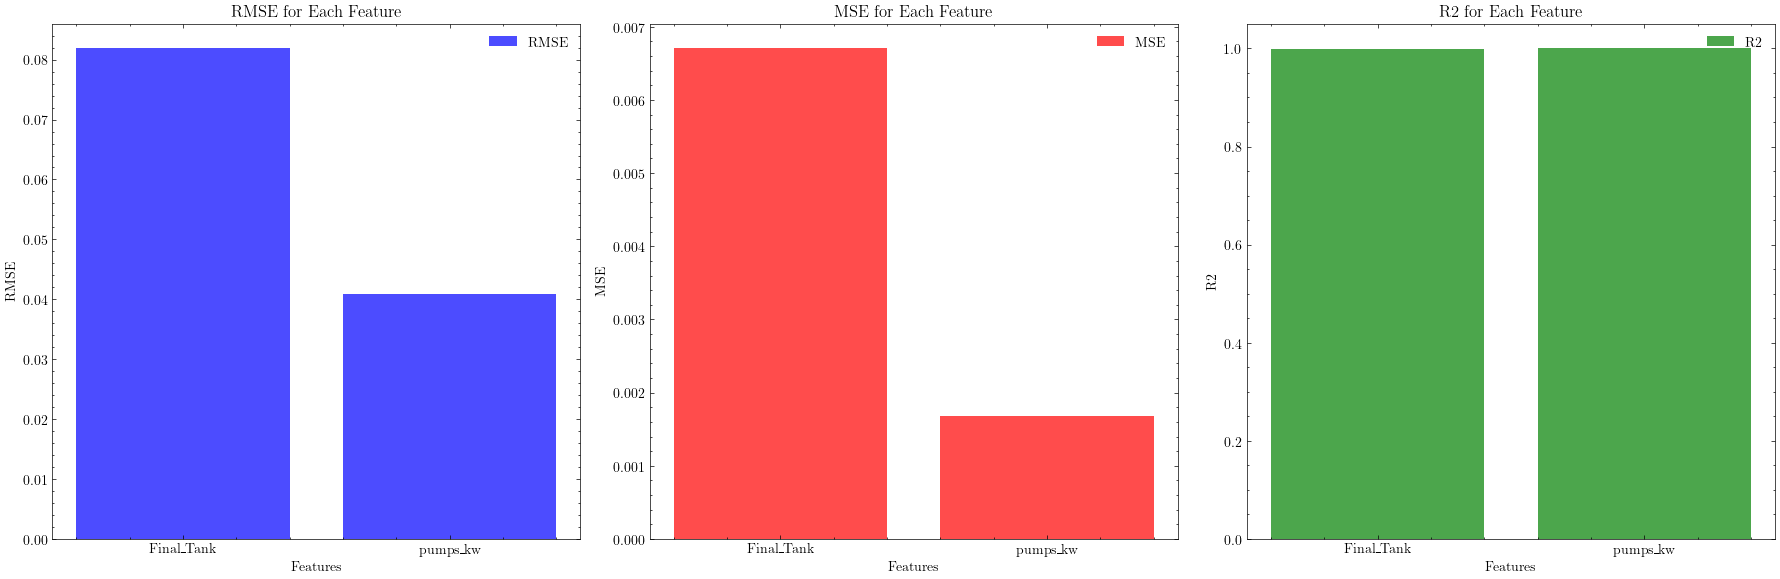

In [25]:
import matplotlib.pyplot as plt
with plt.style.context('science'):
    # Set up the figure and axes
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Bar plot for RMSE
    axs[0].bar(df_metrics2.index, df_metrics2['RMSE'], color='b', alpha=0.7, label='RMSE')
    axs[0].set_title('RMSE for Each Feature')
    axs[0].set_xlabel('Features')
    axs[0].set_ylabel('RMSE')
    axs[0].legend()
    
    # Bar plot for MSE
    axs[1].bar(df_metrics2.index, df_metrics2['MSE'], color='r', alpha=0.7, label='MSE')
    axs[1].set_title('MSE for Each Feature')
    axs[1].set_xlabel('Features')
    axs[1].set_ylabel('MSE')
    axs[1].legend()
    
    # Bar plot for R2
    axs[2].bar(df_metrics2.index, df_metrics2['R2'], color='g', alpha=0.7, label='R2')
    axs[2].set_title('R2 for Each Feature')
    axs[2].set_xlabel('Features')
    axs[2].set_ylabel('R2')
    axs[2].legend()
    
    # Show the plots
    plt.tight_layout()
    #plt.savefig(os.path.join(imagens_tese,"cross_metrics.pdf"), dpi=300)
    plt.show()
    

In [26]:
# Creating a DataFrame from the given metrics
data = {
    'RMSE': {'pumps_kw': 0.000838, 'tank level': 0.007046},
    'MSE': {'pumps_kw': 7.022909e-07, 'tank level': 4.964560e-05},
    'R2': {'pumps_kw': 0.999997, 'tank level': 0.999725}
}

df_given_metrics = pd.DataFrame(data)
df_given_metrics


,RMSE,MSE,R2
pumps_kw,0.000838,7.022909e-07,0.999997
tank level,0.007046,4.964560e-05,0.999725


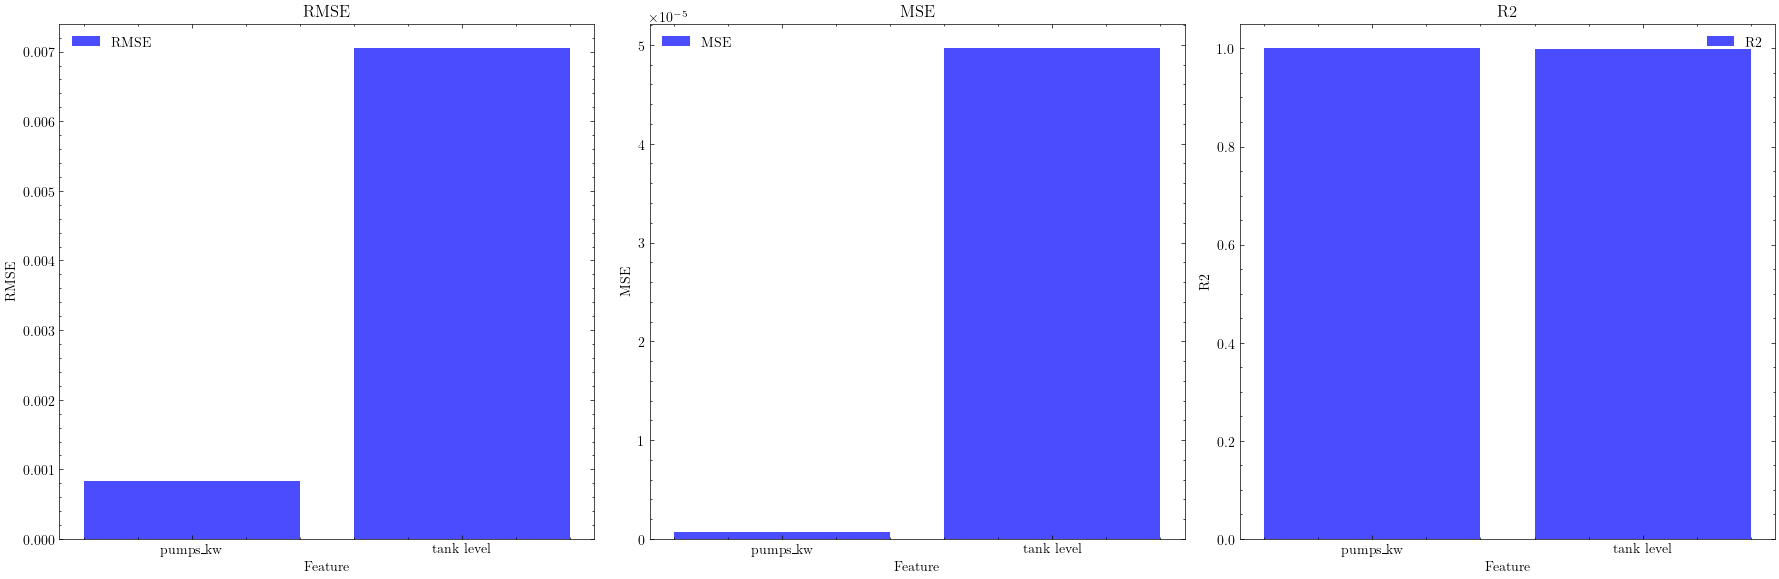

In [27]:
with plt.style.context('science'):

    # Set up the figure and axes for the given metrics, with all bars in blue
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Bar plot for RMSE
    axs[0].bar(df_given_metrics.index, df_given_metrics['RMSE'], color='b', alpha=0.7, label='RMSE')
    axs[0].set_title('RMSE')
    axs[0].set_xlabel('Feature')
    axs[0].set_ylabel('RMSE')
    axs[0].legend()
    
    # Bar plot for MSE
    axs[1].bar(df_given_metrics.index, df_given_metrics['MSE'], color='b', alpha=0.7, label='MSE')
    axs[1].set_title('MSE ')
    axs[1].set_xlabel('Feature')
    axs[1].set_ylabel('MSE')
    axs[1].legend()
    
    # Bar plot for R2
    axs[2].bar(df_given_metrics.index, df_given_metrics['R2'], color='b', alpha=0.7, label='R2')
    axs[2].set_title('R2')
    axs[2].set_xlabel('Feature')
    axs[2].set_ylabel('R2')
    axs[2].legend()
    
    # Show the plots
    plt.tight_layout()
    #plt.savefig(os.path.join(imagens_tese,"cross_metrics2.pdf"), dpi=300)
    plt.show()
    

### Comulated energy

In [28]:
# Pumps Power
energy = (inverse_manual_pred['pumps_kw'])*manual_in['t_step']

energy = pd.DataFrame({'Pumps energy': energy})

In [29]:
real_energy = (data_manual_st['pumps_kw'])*manual_in['t_step']
real_energy = pd.DataFrame({'Pumps energy': real_energy})

In [30]:
pred_accu_e = 0
pred_accumulated_energy = []
for g in range(len(energy)):
    pred_accu_e += energy['Pumps energy'].iloc[g]
    pred_accumulated_energy.append(pred_accu_e)

In [31]:
real_accu_e = 0
real_accumulated_energy = []
for g in range(len(real_energy)):
    real_accu_e += real_energy['Pumps energy'].iloc[g]
    real_accumulated_energy.append(real_accu_e)

In [32]:
pow = potencia_df*1000
with plt.style.context('science'):
    plt.plot(time_hour,real_accumulated_energy, label = 'Epanet')
    plt.plot(time_hour,pred_accumulated_energy, label = 'Predicted')
    plt.plot(time_hour,pow, label = 'Predicted \n pump operation')
    plt.legend(loc='center right')
    plt.title('Accumulated energy')
    plt.xlabel('Hour')
    plt.ylabel('Energy [J]')
    #plt.savefig(os.path.join(imagens_tese,"accumulated_energy.pdf"), dpi=300)
    plt.show

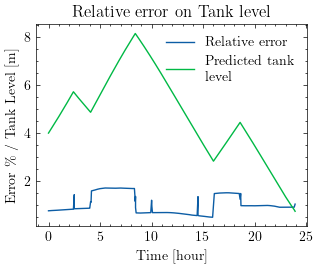

In [43]:

for i in range (len(manual_expected)):
    erro = abs(manual_expected['Final_Tank'] - inverse_manual_pred['Final_Tank'])
    perc = (erro*100)/(manual_expected['Final_Tank'].max()-manual_expected['Final_Tank'].min())
    
 
with plt.style.context('science'):    
    plt.plot(time_hour, perc, label='Relative error')
    plt.plot(time_hour,y_manual_pred_df, label = 'Predicted tank\nlevel')
    plt.xlabel('Time [hour]')
    plt.ylabel('Error \% / Tank Level [m]')
    plt.title('Relative error on Tank level')
    plt.legend()
    plt.savefig(os.path.join(imagens_tese,"error_time.pdf"), dpi=300)
    plt.show()
